# Import libraries

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
from keras.models import Model
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# tf.enable_eager_execution()

Using TensorFlow backend.


# Create a Fully Connected Network

In [2]:
# define the keras model

visible_1 = Input(shape=(978, 2))
flaten_1 = Flatten()(visible_1)
dense_11 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(flaten_1)
drop_1 = Dropout(0.4)(dense_11)
dense_12 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_1)
drop_2 = Dropout(0.4)(dense_12)
dense_13 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_2)
drop_3 = Dropout(0.4)(dense_13)
dense_14 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_3)
drop_4 = Dropout(0.4)(dense_14)
dense_15 = Dense(56, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_4)
output_1 = Dense(1, activation='linear')(dense_15)
sequential = Model(inputs=visible_1, outputs=output_1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Feed Forward model summary

In [3]:
sequential.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 978, 2)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1956)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2003968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1313

# Workflow
Our goal here is to combine the outputs of a FC model and VAE model - a process known as model ensemble (weighted sum)/model stacking (concatenation).
- Af of now, for 781 drugs:
    - For VAE model: features = (for each drug)(277 * 76)(Max_length * #production), labels = lab_experiment_shrinkage_measure(regression_value)
    - For FC model: features = (for each drug)(978 * 2)(#landmark_genes * #replicates), labels = lab_experiment_shrinkage_measure(regression_value)

# Create predictor setup

In [4]:
# Hyperparameters
epochs = 1000
batch_size = 50
# lr = 0.001

In [5]:
# Compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sequential.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error as metrics for regression

# Load dummy datasets

In [6]:
# import h5py

# h5f = h5py.File('../../code/demo_data_train.h5', 'r')
# data_train = h5f['data'][:]
# h5f2 = h5py.File('../../code/demo_labels_train.h5', 'r')
# labels_train = h5f2['data'][:]
# h5f3 = h5py.File('../../code/demo_data_test.h5', 'r')
# data_test = h5f3['data'][:]
# h5f4 = h5py.File('../../code/demo_labels_test.h5', 'r')
# labels_test = h5f4['data'][:]

# print(data_train.shape)
# print(labels_train.shape)
# print(data_test.shape)
# print(labels_test.shape)

# Load gene expression datasets

In [7]:
import h5py

h5f = h5py.File('../', 'r')
data_train = h5f['data'][:]
h5f2 = h5py.File('../../data/y_train_2.h5', 'r')
y_train = h5f2['data'][:]
h5f3 = h5py.File('../../data/gene_exp_data_test_2.h5', 'r')
data_test = h5f3['data'][:]
h5f4 = h5py.File('../../data/y_test_2.h5', 'r')
y_test = h5f4['data'][:]

print(data_train.shape)
print(y_train.shape)
print(data_test.shape)
print(y_test.shape)

(671, 978, 2)
(671,)
(100, 978, 2)
(100,)


In [8]:
y_train

array([-0.47552083, -0.42637563, -0.39997541, -0.35443029,  0.85934851,
        0.93732941, -0.40321856,  0.32073896,  0.80821907,  0.26687206,
       -0.6351139 ,  0.04330822,  0.26930214,  0.68127571,  0.36996815,
       -0.13263653,  0.45947405,  0.08751453,  0.27322222,  0.59692256,
        0.33067291,  0.06469956,  0.20632583,  0.61977997,  0.58589909,
        0.6556439 , -0.01729301, -0.42199853,  0.13982466, -0.84390284,
        0.57081045,  0.39374359, -0.04754193,  0.26689649,  0.76223293,
        0.14200044, -0.52945667,  0.41927055,  0.44988417,  0.74815846,
       -0.74993207, -0.14039316,  0.47716896, -0.05472734,  0.70951138,
       -0.26688348,  0.37885634,  0.28503367, -0.17374533, -0.05918946,
        0.06605688,  0.59841111,  0.11263238,  0.33674551,  0.31656379,
        0.51216439,  0.72570258, -0.60825607,  0.18971139, -0.82215218,
        0.10408353,  0.8863852 , -0.10176809, -0.0256712 , -0.59604276,
        0.30217606,  0.59143902,  0.18806374,  0.33848237,  0.32

In [9]:
# Remove Nan values from data and labels
import numpy as np
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# Remove Inf values from data and labels
data_train[data_train == np.inf] = 0
data_test[data_test == np.inf] = 0
y_train[y_train == np.inf] = 0
y_test[y_test == np.inf] = 0

# Load pretrained weights

In [10]:
# sequential.load_weights('../../data/sequential.h5')

# Train the model

In [11]:
# # learning rate schedule
# import math
# def step_decay(epoch):
#     initial_lrate = 0.0001
#     drop = 0.01
#     epochs_drop = 100.0
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     return lrate

In [12]:
# Set up ModelCheckpoint to save weights for the epoch with the best validation loss
# checkpoint_filepath = "../../data/seq_weights.h5"
checkpoint_filepath = "../../data/seq_weights_lr_sched_2.h5"
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [13]:
# Train the model
# epochs = 1000
# batch_size = 50
# lr_scheduler = LearningRateScheduler(step_decay)
history = sequential.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint])


Train on 671 samples, validate on 100 samples
Epoch 1/1000
 - 1s - loss: 0.2150 - mae: 0.3506 - val_loss: 0.1983 - val_mae: 0.3317

Epoch 00001: val_loss improved from inf to 0.19829, saving model to ../../data/seq_weights_lr_sched_2.h5
Epoch 2/1000
 - 1s - loss: 0.2102 - mae: 0.3418 - val_loss: 0.1957 - val_mae: 0.3189

Epoch 00002: val_loss improved from 0.19829 to 0.19566, saving model to ../../data/seq_weights_lr_sched_2.h5
Epoch 3/1000
 - 1s - loss: 0.2014 - mae: 0.3363 - val_loss: 0.1958 - val_mae: 0.3226

Epoch 00003: val_loss did not improve from 0.19566
Epoch 4/1000
 - 1s - loss: 0.2004 - mae: 0.3313 - val_loss: 0.1953 - val_mae: 0.3218

Epoch 00004: val_loss improved from 0.19566 to 0.19526, saving model to ../../data/seq_weights_lr_sched_2.h5
Epoch 5/1000
 - 1s - loss: 0.1942 - mae: 0.3294 - val_loss: 0.1945 - val_mae: 0.3213

Epoch 00005: val_loss improved from 0.19526 to 0.19447, saving model to ../../data/seq_weights_lr_sched_2.h5
Epoch 6/1000
 - 1s - loss: 0.1946 - mae:

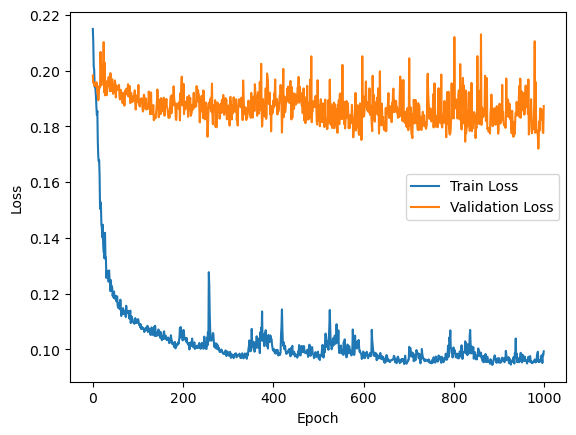

In [14]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

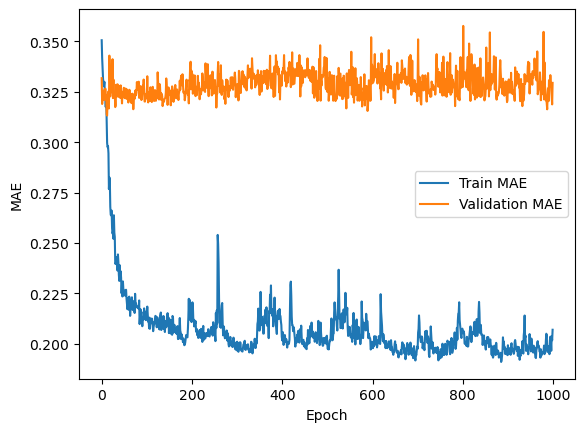

In [15]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [16]:
# Load the best weights based on the optimal epoch
sequential.load_weights(checkpoint_filepath)

# Evaluate the model

In [17]:
# Evaluate the model on the test set
results = sequential.evaluate(data_test, y_test, batch_size=batch_size)

100/100 [==============================] - 0s 287us/step


# Results

In [18]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 0.17203303426504135
Test MAE: 0.3162980377674103


In [19]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 988 loss: 0.17203303426504135


[[1.         0.13198288]
 [0.13198288 1.        ]]
0.012715375758292069


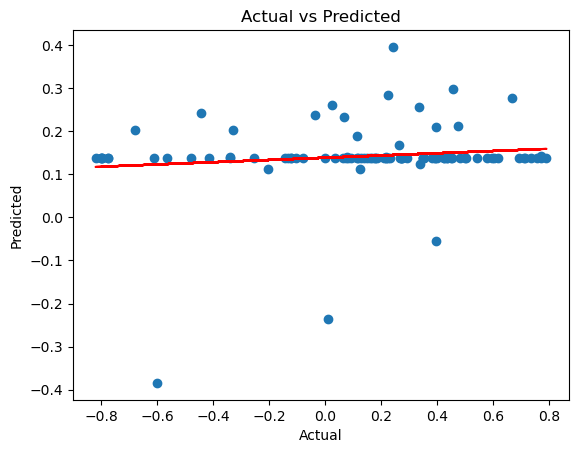

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = sequential.predict(data_test)
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Save model weights

In [21]:
# sequential.save_weights('../../data/sequential.h5')
# print("Model weights saved to 'sequential.h5'")

# Finish!

# Test the model

In [22]:
# Load test set for gene expression data
h5f = h5py.File('../../data/gene_exp_test_data.h5', 'r')
seq_test_data = h5f['data'][:]
# h5f = h5py.File('../../data/vae_test_data.h5', 'r')
# vae_test_data = h5f['data'][:]

print(seq_test_data.shape)
# print(vae_test_data.shape)

(910, 978, 2)


In [23]:
from densenet import DenseNet

model = DenseNet()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 978, 2)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1956)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2003968   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1313